Thanks to 

http://kvfrans.com/simple-algoritms-for-solving-cartpole/

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym

#  The problem

Given 4 numeric values representing observations
select the base action 1 or -1 so that the total reward during a episode is maximised.

Solution a linear model where we move left if the output is less than 0 otherwise we move right.

How to solve the linear problem so that we can find the set of parameters that maximize the reward?

In [47]:
parameters = np.random.rand(4) * 2 - 1

In [48]:
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        #Get +1 in reward each timestep
        totalreward += reward
        if done:
            break
    return totalreward

# Method 1
## Random search

Just randomly jump around in parameter space trying to find a good configuration

In [49]:
def random_search_policy():
    bestparams = None
    bestreward = 0
    for i in range(10000):
        parameters = np.random.rand(4) * 2 - 1
        reward = run_episode(env, parameters)
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            # Considered solved if agent lasts 200 timesteps
            if reward == 200:
                break
    return i, bestparams, bestreward

In [50]:
envname = 'CartPole-v0'
env = gym.make(envname)
episodes_to_200 = []
for _ in range(1000):
    episodes, _, _ = random_search_policy()
    episodes_to_200.append(episodes)

[2017-02-18 22:34:47,109] Making new env: CartPole-v0


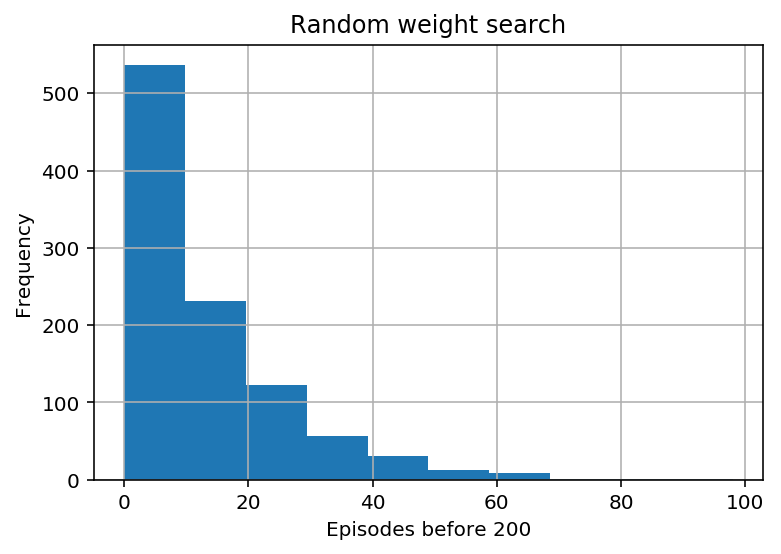

12.814


In [55]:
df = pd.Series(episodes_to_200)#.value_counts(normalize=True)
df.hist()
plt.title("Random weight search")
plt.xlabel("Episodes before 200")
plt.ylabel("Frequency")
plt.show()

print(df.mean())

# Method 2
## Hill-Climbing
Randomly initialize weights. Add som nose to weights,
keep the new weights if the policy is improved by the noice.

In [58]:
def hill_climbing_policy():
    noise_scaling = 0.1
    parameters = np.random.rand(4) * 2 - 1  
    bestreward = 0
    allrewards = []
    for i in range(10000):
        newparams = parameters + (np.random.rand(4) * 2 - 1) * noise_scaling
        reward = 0
        run = run_episode(env,newparams)
        if reward > bestreward:
            bestreward = reward
            parameters = newparams
            allrewards.append(reward)
            if reward == 200:
                break
    return i, parameters, bestreward

In [59]:
envname = 'CartPole-v0'
env = gym.make(envname)
episodes_to_200 = []
for i in range(1000):
    episode, _ ,_ = hill_climbing_policy()
    episodes_to_200.append(episode)
    if i % 10 == 0:
        print('Episode: ', i)

[2017-02-18 22:38:30,923] Making new env: CartPole-v0


Episode:  0
Episode:  10
Episode:  20
Episode:  30
Episode:  40
Episode:  50
Episode:  60
Episode:  70
Episode:  80
Episode:  90
Episode:  100
Episode:  110
Episode:  120
Episode:  130
Episode:  140
Episode:  150
Episode:  160
Episode:  170
Episode:  180
Episode:  190
Episode:  200
Episode:  210
Episode:  220
Episode:  230
Episode:  240
Episode:  250
Episode:  260
Episode:  270
Episode:  280
Episode:  290
Episode:  300
Episode:  310
Episode:  320
Episode:  330
Episode:  340
Episode:  350
Episode:  360
Episode:  370
Episode:  380
Episode:  390
Episode:  400
Episode:  410
Episode:  420
Episode:  430
Episode:  440
Episode:  450
Episode:  460
Episode:  470
Episode:  480
Episode:  490
Episode:  500
Episode:  510
Episode:  520
Episode:  530
Episode:  540
Episode:  550
Episode:  560
Episode:  570
Episode:  580
Episode:  590
Episode:  600
Episode:  610
Episode:  620
Episode:  630
Episode:  640
Episode:  650
Episode:  660
Episode:  670
Episode:  680
Episode:  690
Episode:  700
Episode:  710
Epi

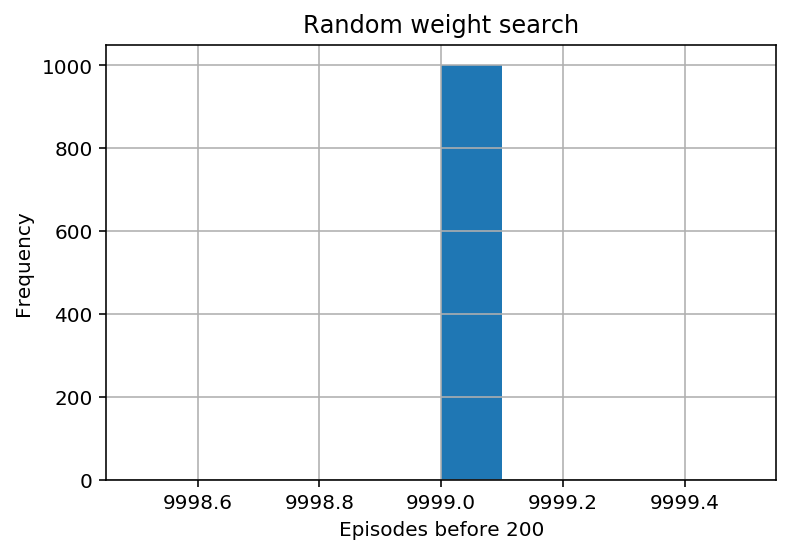

In [61]:
df = pd.Series(episodes_to_200)#.value_counts(normalize=True)
df.hist()
plt.title("Random weight search")
plt.xlabel("Episodes before 200")
plt.ylabel("Frequency")
plt.show()

# Method 3
## Policy Gradient
Switch from determenistic policy to stochastic policy.

Goal is to condition a distribution of actions so that it selects the correct action with high probability.

In [62]:
import tensorflow as tf

In [68]:
def policy_gradient():
    '''
    Defines how to update the policy to prefere certain
    actions.
    If we had an oracle problem would be solved.
    (If we can learn a env we can use optimal control to get an oracle)
    '''
    params = tf.get_variable("policy_parameters", [4,2])
    state = tf.placeholder("float", [None,4])
    actions = tf.placeholder("float",[None,2])
    linear = tf.matmul(state,params)
    probabilities = tf.nn.softmax(linear)
    good_probabilities = tf.reduce_sum(tf.mul(probabilities, actions),reduction_indices=[1])
    print(state.run(good_probabilities))
    #maximize the log probability
    log_probabilities = tf.log(good_probabilities)
    loss = -tf.reduce_sum(log_probabilities)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    return probabilities, state, actions, advantages, optimizer

How can we know how good it is to take an action from a state?
Well we can not but we can approximate it by calculate the expected reward from this state onward. basing the current states value based on future approximations is called bootstraping.

In [67]:
def value_gradient():
    '''
    The expected value is the average over all actions
    from this state.
    '''
    state = tf.placeholder(tf.float64, [None, 4])
    w1 = tf.get_variable('w1', [4,10])
    b1 = tf.get_variable('b1',[10])
    h1 = tf.nn.relu(tf.matmul(state,w1) + b1)
    w2 = tf.get_variable('w2',[10,1])
    b2 = tf.get_variable('b2',[1])
    calculated = tf.matmul(h1,w2) + b2
    
    newvals = tf.placeholder(tf.float64, [None,1])
    diffs = calculated - newvals
    loss = tf.nn.l2_loss(diffs)
    optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
    
    return calculated, state, newvals, optimizer, loss


In [69]:
pl_probabilities, pl_state = policy_gradient()
observation = env.reset()
actions = []
transitions = []
# Generate 200 rollouts
for i in range(200):
    #calculate policy
    obs_vector = np.expand_dims(observation,axis=0)
    probs = sess.run(pl_probabilities,feed_dict={pl_state: obs_vector})
    actions = 0 if random.uniform(0,1) < probs[0][0] else 1
    
    #record transition
    states.append(observation)
    actionblank = np.zeros(2)
    actionblank[action] = 1
    actions.append(actionblank)
    
    #take the action in the environment
    old_observation = observation
    observation, reward, done, info = env.step(action)
    transitions.append((old_observation, action, reward))
    totalreward += reward
    
    if done:
        break

AttributeError: module 'tensorflow' has no attribute 'mul'

In [ ]:
vl_calculated, vl_state, vl_newvals, vl_optimizer, vl_loss = value_grad
update_vals = []
for index, trans in enumerate(transitions):
    obs, action, reward = trans
    # calculate discounted monte-carlo return
    future_reward = 0
    future_transitions = len(transitions) - index
    decrease = 1
    for index2 in range(future_transitions):
        #discounted sum of returns
        future_reward += transitions[(index2) + index][2] * decrese
        decrease = decrease * .97
    update_vals.append(future_reward)
update_vals_vector = np.expand_dims(update_vals, axis=1)
sess.run(vl_optimizer, feed_dict={vl_state: states, vl_newvals: update_vals_vector})
    